## To-do
* add documentation and check inputs to functions
* try splitting data based on temperature when using data from all cities
* create model of form: N100 = a + exp(b\*T + c) + d\*CO
    * don't transform N100
    * train multiple sub-models (2?) and combine them
        * depending on temperature: when the temperature is high, CO should be almost irrelevant

## Notes
* **Data**
    * use additional data?
        * precipitation 
        * boundary layer height
    * remove outliers before normalizing? 
        * how to identify outliers?
    * focus on HYY, KPZ, NAN, MLP for now, then look at data from all cities combined
        * NAN (high pollution) and KPZ (medium pollution) are very small datasets
        * MLP is a moderately small dataset and has high pollution
        * HYY is the biggest dataset and has low pollution
    * when using all datasets: not all cities contribute the same amount of data points 
        * test making differently sized datasets equally valuable
            * leave a few (3? - one for each pollution type) datasets out for testing
* **Model**
    * look into interpretability of random forest models
        * random forests perform a lot better than linear regression when using a simple model
    * look into using a combination of decision trees and linear regression models
        * splitting data based on features such as temperature
        
    
## Results
* **using dates as predictor**
    * using sin and cos of day of the year makes model performance worse, using the month improves it a bit, performance of using season or week of the year doesn't fiffer much from using the month of the year
        * using 10 "seasons" gives the best results
        * the 0th and last seasons only have about half as many data points as the other seasons, but combining them makes the model worse 
* **most errors seem to occur in the summer**
* **high N100 concentrations are strongly underestimated**
    * see model for high temperatures below
    * not yet applied for whole case where all cities are used
* **differences between southern and northern hemisphere climates**
    * including lat and lon improves model significantly
    * taking negative value of cities in southern hemisphere makes model a bit better if also using lat and lon, otherwise it gets worse
* **strength of predictors (all datasets)**
    1. Temperature
    2. Carbon Monoxide
    3. Previous Week Average
    4. Latitude and Longitude
    5. Season

### Model comparisons
* **model trained on HYY data with all predictors where pwa = 7 (better than 14)**
    * Model equation: log(N100) = 2.275\*min_max(T) - 1.111\*min_max(T_PWA) + 1.456\*log(CO) - 0.703\*log(CO_PWA) + 0.139\*sin(Season) - 0.493\*cos(Season) - 2.0
    * Correlation between observed and predicted log-transformed N100 concentration: 0.584
    * Correlation between observed and predicted N100 concentration: 0.571
    * R2 score on test set: 0.292
    * RMSE on test set: 271.779
* **model trained on HYY subset where temperature is high and pwa = 14**
    * Model equation: log(N100) = 8.623\*min_max(T) - 4.256\*min_max(T_PWA) - 5.496
    * Correlation between observed and predicted log-transformed N100 concentration: 0.707
    * Correlation between observed and predicted N100 concentration: 0.684
    * R2 score on test set: 0.460
    * RMSE on test set: 250.871

## Importing Libraries

In [1]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import geopandas as gpd

from shapely.geometry import Point

from scipy.signal import find_peaks, argrelmin
from scipy.stats import pearsonr

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Initiating directories

In [2]:
ROOT_DIR = os.getcwd() + '/../'

try:
    with open (ROOT_DIR + '/configuration.yml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')

DATA_DIR = ROOT_DIR + config['data']['final'] + '/'

cities = pd.read_csv(ROOT_DIR + config['cities'])
unique_cities = cities.city.unique()

### City abbreviations

* **ALE:**	Alert, Canada
* **ABZ:**	Annaberg-Buchholz, Germany
* **ASP:**	Aspvreten, Sweden
* **BOT:**	Botsalano, South Africa
* **BSL:**	Bösel (Südoldenburg), Germany
* **EGB:**	Egbert, Canada
* **HEL:**	Helsinki, Finland
* **HPB:**	Hohenpeissenberg, Germany
* **HYY:**	Hyytiälä, Finland
* **KCE:**	Kosetice, Czech Republic
* **KPZ:**	K-Puszta, Hungary
* **MHD:**	Mace Head, Ireland
* **MAR:**	Marikana, South Africa
* **MLP:**	Melpitz, Germany
* **NAN:**	Nanjing, China
* **NEU:**	Neuglobsow, Germany
* **SAO:**	São Paulo, Brazil
* **SCH:**	Schauinsland, Germany
* **SGP:**	Southern Great Plains, Oklahoma, US
* **VIE:**	Vielsalm, Belgium
* **VAR:**	Värriö, Finland
* **WAL:**	Waldhof, Germany

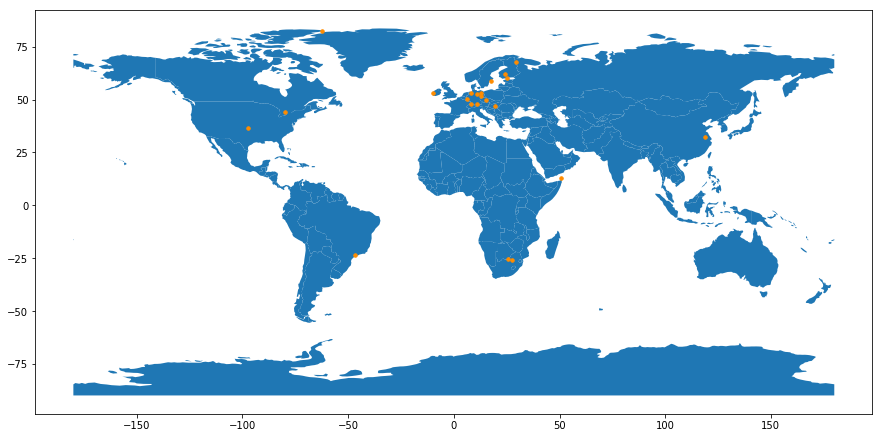

In [3]:
geometry = [Point(xy) for xy in zip(cities.longitude, cities.latitude)]
gdf = gpd.GeoDataFrame(cities.city, crs={'init': 'epsg:4326'}, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(figsize=(15,10))
gdf.plot(ax=ax, color='darkorange', markersize=12);

## Loading and pre-processing the data
### Selecting whether to use all or only one city

In [4]:
def select_cities(city_name='HYY'):
    selected_city = ''

    if use_all_cities:
        selected_city = 'all cities'
        print('Selected:')
        print(unique_cities, '\n')
    else:
        selected_city = city_name
        print('Selected:', selected_city)
    
    return selected_city

### Selecting which predictors to use in the model

In [5]:
def select_predictors():
    predictors = []
    eq_variables = []

    if use_t:
        predictors.append('t')
        eq_variables.append('min_max(T)')
        if use_pwa:
            predictors.append('t_pwa')
            eq_variables.append('min_max(T_PWA)')
    if use_co:
        predictors.append('co')
        eq_variables.append('log(CO)')
        if use_pwa:
            predictors.append('co_pwa')
            eq_variables.append('log(CO_PWA)')
    if use_season:
        predictors.extend(['season_sin', 'season_cos'])
        eq_variables.extend(['sin(Season)', 'cos(Season)'])
    if use_lat_lon and use_all_cities:
        predictors.extend(['lat', 'lon'])
        eq_variables.extend(['Lat', 'Lon'])

    print('Using predictors:', predictors, '\n')
    return predictors, eq_variables

### Calculating the season 

In [6]:
def add_seasons(df, no_seasons):
    dates = df.index.tolist()
    season = [datetime.datetime.strptime(dates[i], "%Y-%m-%d").date() for i in range(len(dates))]
    season = np.array([season[i].timetuple().tm_yday for i in range(len(season))])
    season = season / (365/no_seasons)
    season = np.round(season)
#     season[season == no_seasons] = 0

    # adding the sin and cos of season to the dataframe
    df['season_sin'] = np.sin(2*np.pi * season/len(np.unique(season)))
    df['season_cos'] = np.cos(2*np.pi * season/len(np.unique(season)))
    
    # mirroring season variables for cities in the southern hemisphere
    if use_all_cities:
        df.loc[df.lat < 0, ['season_sin', 'season_cos']] *= -1
    
    return df, dates, season

## Calculating the previous week averages (pwa)
(excludes the day measured in the t and co columns)

In [7]:
def add_pwa(df, pwa):
    if use_all_cities:
        # creating a unique id for every row
        df['id'] = df.city + df.index

        for col in ['t', 'co']:
                df_pwa = []
                names_pwa = []

                for city in unique_cities:
                    subset = df.loc[df.city == city]
                    new_df = pd.DataFrame()

                    for i in range(1, pwa+1):
                        new_df[col + '_' + str(i)] = subset.shift(i)[col]

                    new_df = new_df.aggregate(np.mean, axis=1)[pwa:]
                    df_pwa.extend(new_df)
                    names_pwa.extend(subset.id[pwa:])
                
                df_pwa = pd.Series(df_pwa, index=names_pwa, name=col+'_pwa')
                df = df.join(df_pwa, how='inner', on='id', )
    
        df.drop(columns='id', inplace=True)
    else:
        for col in ['t', 'co']:
            new_df = pd.DataFrame()
            for i in range(1, pwa+1):
                new_df[col + '_' + str(i)] = df.shift(i)[col]
            new_df = new_df.aggregate(np.mean, axis=1)
            df[col + '_pwa'] = new_df

        # removing the rows containing NaN values in the previous 7 days
        df = df[pwa:] 
    
    return df

### Creating the dataset

In [8]:
def create_df(no_seasons, pwa):
    df = None
    numeric = ['n100'] + predictors
    non_numeric =[]

    if use_all_cities:
        df = pd.read_csv(DATA_DIR + 'all_merged.csv', index_col='date')
        df.columns = ['n100', 't', 'co', 'city', 'lat', 'lon']
        non_numeric += ['city']
        
        df.lat /= 90  # divide latitudes by 90
        df.lon /= 180  # divide longitudes by 180

    else:
        df = pd.read_csv(DATA_DIR + selected_city + '.csv', index_col='date')
        df.columns = ['n100', 't', 'co']
        
    dates = None
    season = None
    
    if use_season:
        df, dates, season = add_seasons(df, no_seasons)

    if use_pwa:
        df = add_pwa(df, pwa)
    
    # setting all values that are equal to 0 to 0.000001 to avoid infinities
    df[numeric] = df[numeric].replace(0, 0.000001)

    # reordering columns
    df = df[numeric + non_numeric]

    # dropping the index of the dataframe
    dates = df.index.tolist()
    df = df.reset_index(drop=True)

    print('Number of data points:', df.shape[0])

    return df, dates, season, numeric, non_numeric

### Transforming the data

In [9]:
def transform_df(df):
    # normalizing the data
    min_max_scaler = preprocessing.MinMaxScaler()
    trans_idx = 1 + len(predictors) - use_season*2 - (use_lat_lon and use_all_cities)*2

    x_scaled = min_max_scaler.fit_transform(df.iloc[:,0:trans_idx].values)
    x_scaled = np.concatenate((x_scaled, df.iloc[:,trans_idx:].values), axis=1)

    df_scaled = pd.DataFrame(x_scaled)
    df_scaled.columns = df.columns.values
    df_scaled[numeric] = df_scaled[numeric].astype('float32')

    # log-transforming the data
    df_log = df_scaled.iloc[:,0:trans_idx].transform(np.log)
    df_log = pd.concat([df_log, df.iloc[:,trans_idx:]], axis=1)
    
    return df_scaled, df_log

### Removing rows that contain infinities in log-transformed dataset

In [10]:
def remove_infinities(df, df_log, df_scaled, dates):
    subset_mask = np.isinf(df_log[numeric]).any(axis=1) == False

    df = df.loc[subset_mask].reset_index(drop=True)
    df_log = df_log.loc[subset_mask].reset_index(drop=True)
    df_scaled = df_scaled.loc[subset_mask].reset_index(drop=True)
    dates = pd.Series(dates).loc[subset_mask].reset_index(drop=True)

    print('Number of removed rows:', sum(subset_mask ==False))
    
    return df, df_log, df_scaled, dates

### Combining the transformed datasets into one dataframe

In [11]:
def combine_data(df, df_log, df_scaled):
    df_comb = [df_log.n100]  # log-transformed N100 concentration

    if use_t:
        df_comb.append(df_scaled.t)  # min-max scaled temperature
        if use_pwa:
            df_comb.append(df_scaled.t_pwa)  # PWA of min-max scaled temperature
    if use_co:
        df_comb.append(df_log.co)  # log-transformed CO concentration
        if use_pwa:
            df_comb.append(df_log.co_pwa)  # PWA of log-transformed CO concentration
    if use_season:
        df_comb.extend([df.season_sin, df.season_cos])  # sin and cos of seasons
    if use_lat_lon and use_all_cities:
        df_comb.extend([df.lat, df.lon])  # latitude and longitude
    if use_all_cities:
        df_comb.append(df.city)  # city

    df_comb = pd.DataFrame(np.array(df_comb).T)
    df_comb.columns = df.columns.values
    
    print('Number of data points:', df_comb.shape[0], '\n')
        
    return df_comb

## Splitting data into train and test sets

In [12]:
def split_data(df, df_comb, dates):
    # splitting the data into training (75%) and testing (25%) sets
    split = int(len(df_comb) * 0.75)  # index to split the data on

    # dates
    dates_test = dates[split:]

    # n100
    y_train= df_comb.n100[:split]
    y_test = df.n100[split:].reset_index(drop=True)
    log_y_test = df_comb.n100[split:].reset_index(drop=True)
    log_y_test = np.array(log_y_test, dtype='float64')

    # predictors
    X_train = df_comb[predictors][0:split]
    X_test = df_comb[predictors][split:].reset_index(drop=True)

    # fitting a min_max_scaler to the concentration data so that predicted values can be reverse transformed
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler = min_max_scaler.fit(df.n100.values.reshape(-1,1))

    print('Train set shapes:', X_train.shape, 'and', y_train.shape)
    print('Test set shapes:', X_test.shape, 'and', y_test.shape, '\n')

    if use_all_cities:
        print('Cities in test set:', list(df_comb.city[split:].unique()))
        
    return y_train, y_test, log_y_test, X_train, X_test, dates_test, min_max_scaler

### Functions for exploratory data visualizations

In [13]:
def plot_distributions(df_scaled, df_comb, season, bins=100):
    histtype = 'stepfilled'

    fig, ax = plt.subplots(2, 3)
    fig.set_figwidth(15)
    fig.set_figheight(10)

    i = 0
    for col in ['n100', 't', 'co']:
        ax[0, i].hist(np.array(df_scaled[col]), bins=bins, histtype=histtype)
        hist = np.histogram(np.array(df_comb[col]), bins=bins)
        width = hist[1][1:] - hist[1][:-1]

        if col != 't':
            ax[1, i].bar(hist[1][:-1] + (width/2), hist[0], width=width)
        else:
            seasons_unique, seasons_count = np.unique(season, return_counts=True)
            ax[1, i].bar(seasons_unique, seasons_count)
        i += 1

    ax[0, 0].set_title('N100 Concentration (min-max scaled)')
    ax[0, 1].set_title('Temperature (min-max scaled)')
    ax[0, 2].set_title('Carbon Monoxide (min-max scaled)')

    ax[1, 0].set_title('N100 Concentration (log-transformed)')
    ax[1, 1].set_title('Seasons')
    ax[1, 2].set_title('Carbon Monoxide (log-transformed)')
    
def plot_trends(df_comb, dates, window_size=30):
    df_comb_ma = df_comb.copy()
    df_comb_ma = df_comb_ma[numeric].rolling(window=window_size).mean()
    df_comb_ma = pd.concat([df_comb_ma, df[non_numeric]], axis=1)[window_size:]

    idx = df_log.shape[0]
    step = int(idx / 10)
    xticks_mask = list(range(0, idx, step))
    xticks = pd.Series(dates).iloc[xticks_mask]

    fig, ax = plt.subplots(3, 1)
    fig.set_size_inches(15,14)

    ax[0].plot(df_comb.n100[:idx], label='N100 Concentration')
    ax[0].plot(df_comb_ma.n100[:idx], label='Rolling Mean')

    ax[1].plot(df_comb.t[:idx], label='Temperature', c='green')
    ax[1].plot(df_comb_ma.t[:idx], label='Rolling Mean', c='red')

    ax[2].plot(df_comb.co[:idx], label='Carbon Monoxide', c='purple')
    ax[2].plot(df_comb_ma.co[:idx], label='Rolling Mean', c='yellow')

    for i in range(3):
        ax[i].legend()
        ax[i].set_xticks(xticks_mask)
        ax[i].set_xticklabels(xticks)

    fig.tight_layout(pad=4)
    fig.suptitle('Transformed Data and Rolling Means for '+selected_city)
    
def plot_correlations(df_comb):
    rows = 4 if use_all_cities else 3
    cols = 2

    fig, ax = plt.subplots(rows, cols)
    fig.set_size_inches(10, 18)
    fig.suptitle('Correlations between N100 Concentration and Predictors for '+selected_city)

    # plotting the data
    ax[0, 0].scatter(df_comb.t, df_comb.n100, s=2, alpha=alpha)
    ax[0, 1].scatter(df_comb.t_pwa, df_comb.n100, s=2, alpha=alpha)
    ax[1, 0].scatter(df_comb.co, df_comb.n100, s=2, alpha=alpha)
    ax[1, 1].scatter(df_comb.co_pwa, df_comb.n100, s=2, alpha=alpha)
    ax[2, 0].scatter(df_comb.season_sin, df_comb.n100, s=2, alpha=alpha)
    ax[2, 1].scatter(df_comb.season_cos, df_comb.n100, s=2, alpha=alpha)
    
    if use_all_cities:
        ax[3, 0].scatter(df_comb.lat, df_comb.n100, s=2, alpha=alpha)
        ax[3, 1].scatter(df_comb.lon, df_comb.n100, s=2, alpha=alpha)

    # setting x-axis limits
    ax[1, 0].set_xlim(-7.5, 0)
    ax[1, 1].set_xlim(-7.5, 0)
    ax[2, 0].set_xlim(-1, 1)
    ax[2, 1].set_xlim(-1, 1)
    
    if use_all_cities:
        ax[3, 0].set_xlim(-1, 1)
        ax[3, 1].set_xlim(-1, 1)

    # labelling the axes
    ax[0, 0].set_xlabel('Temperature (min-max scaled)')
    ax[0, 1].set_xlabel('Previous Week Average of Temperature\n(min-max scaled)')
    ax[1, 0].set_xlabel('Carbon Monoxide (log-transformed)')
    ax[1, 1].set_xlabel('Previous Week Average of Carbon Monoxide\n(log-transformed)')
    ax[2, 0].set_xlabel('Sine of Season')
    ax[2, 1].set_xlabel('Cosine of Season')
    
    if use_all_cities:
        ax[3, 0].set_xlabel('Latitude')
        ax[3, 1].set_xlabel('Longitude')

    for i in range(rows):
        for j in range(cols):
            ax[i, j].set_ylim(-7.5, 0)
            ax[i, j].set_ylabel('N100 Concentration (log-transformed)')

    # adding correlation coefficients
    def get_corr(a, b, pr=3):
        corr = pearsonr(a, b)[0]
        corr = np.round(corr, pr)
        return str(corr)

    ax[0, 0].text(0.8, -7, 'p = ' + get_corr(df_comb.t, df_comb.n100), weight='bold')
    ax[0, 1].text(0.8, -7, 'p = ' + get_corr(df_comb.t_pwa, df_comb.n100), weight = 'bold')
    ax[1, 0].text(-7, -7, 'p = ' + get_corr(df_comb.co, df_comb.n100), weight = 'bold')
    ax[1, 1].text(-7, -7, 'p = ' + get_corr(df_comb.co_pwa, df_comb.n100), weight = 'bold')
    ax[2, 0].text(-0.9, -7, 'p = ' + get_corr(df_comb.season_sin, df_comb.n100), weight = 'bold')
    ax[2, 1].text(-0.9, -7, 'p = ' + get_corr(df_comb.season_cos, df_comb.n100), weight = 'bold')
    
    if use_all_cities:
        ax[3, 0].text(-0.9, -7, 'p = ' + get_corr(df_comb.lat, df_comb.n100), weight = 'bold')
        ax[3, 1].text(-0.9, -7, 'p = ' + get_corr(df_comb.lon, df_comb.n100), weight = 'bold')

    fig.tight_layout(pad=4)

### Functions for evaluating models

In [14]:
# function for reverse transforming the data
def rev_trans(predictions):
    predictions = np.exp(predictions)
    predictions = min_max_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

# function for printing the equation created by the linear regression model
def print_equation(model):
    coefs = np.round(model.coef_, pr)
    intercept = np.round(model.intercept_, pr)
    
    equation = 'Model equation:\nlog(N100) ='
    
    for i in range(len(coefs)):
        if coefs[i] < 0:
            equation += ' - '
        elif i == 0:
            equation += ' '
        else:
            equation += ' + '
        
        equation += str(np.abs(coefs[i]))
        equation += '*' + eq_variables[i]
    
    if intercept < 0:
        equation += ' - '
    else:
        equation += ' + '
    
    equation += str(np.abs(intercept)) + '\n'               
    print(equation)

# function for calculating the R2 value and RMSE
def eval_model(predictions, model):
    r2 = r2_score(y_test, predictions)
    print('R2 score on test set:\n%.3f\n' % r2)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print('RMSE on test set:\n%.3f\n' % rmse)

# function for plotting the log-transformed observed and predicted n100 concentrations against each other
def log_log_eval(log_predictions):
    plt.figure(figsize=(5, 5))
    plt.title('Observed vs. Predicted Log-Transformed N100 Concentration')
    
    axis_min, axis_max = -7, 0
    
    # plotting the line of perfect fit
    plt.plot(list(range(axis_min, axis_max+1)), list(range(axis_min, axis_max+1)), c='black', alpha=0.25)
    
    # plotting a line fitting the data
    poly = np.polyfit(log_y_test, log_predictions, 1)
    x = np.linspace(axis_min, axis_max, 100)
    y = poly[0]*x + poly[1]
    plt.plot(x, y, c='orange', alpha=0.75)
    
    # plotting the data
    plt.scatter(log_y_test, log_predictions, s=2, alpha=alpha)
    
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    print('Correlation between observed and predicted log-transformed N100 concentration:\n%.3f\n' %
          np.corrcoef(log_y_test, log_predictions)[0, 1])

# function for plotting the observed and predicted n100 concentrations against each other
def corr_eval(predictions):
    plt.figure(figsize=(5, 5))
    plt.title('Observed vs. Predicted N100 Concentration')
    
    axis_min, axis_max = 0, int(y_test.max())
    
    # plotting the line of perfect fit
    plt.plot(list(range(axis_min, axis_max+1)), list(range(axis_min, axis_max+1)), c='black', alpha=0.25)
    
    # plotting a line fitting the data
    poly = np.polyfit(y_test, predictions, 1)
    x = np.linspace(axis_min, axis_max, 100)
    y = poly[0]*x + poly[1]
    plt.plot(x, y, c='orange', alpha=0.75)
    
    # plotting the data
    plt.scatter(y_test, predictions, s=2, alpha=alpha)
    
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    print('Correlation between observed and predicted N100 concentration:\n%.3f\n' %
          np.corrcoef(y_test, predictions[:,0])[0, 1])
    
# function for plotting the predicted and observed n100 concentrations
def plot_results(name, predictions):
    plt.figure(figsize=(15,5))
    plt.title('Performance of ' + name + ' Model - ' + selected_city + ' - Test Set')
    
    plt.plot(np.array(y_test), label='Observed')
    plt.plot(predictions, label='Predicted')
    
    xticks_mask = list(range(0, dates_test.shape[0], int(dates_test.shape[0] / 8)))
    xticks = dates_test.iloc[xticks_mask]
    plt.xticks(xticks_mask, xticks)
    
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('N100 concentration')

## Creating the dataframes

In [15]:
city_name = 'HYY'
no_seasons = 10
pwa = 7

use_all_cities = False
use_t = True
use_co = True
use_pwa = True
use_season = True
use_lat_lon = True

selected_city = select_cities(city_name)
predictors, eq_variables = select_predictors()
df, dates, season, numeric, non_numeric = create_df(no_seasons, pwa)

df_scaled, df_log = transform_df(df)
df, df_log, df_scaled, dates = remove_infinities(df, df_log, df_scaled, dates)
df_comb = combine_data(df, df_log, df_scaled)

print('Shape of combined dataframe', df_comb.shape)
df_comb.head()

Selected: HYY
Using predictors: ['t', 't_pwa', 'co', 'co_pwa', 'season_sin', 'season_cos'] 

Number of data points: 5814
Number of removed rows: 5
Number of data points: 5809 

Shape of combined dataframe (5809, 7)


,n100,t,t_pwa,co,co_pwa,season_sin,season_cos
0,-3.192179,0.307211,0.037555,-0.960064,-0.220608,0.000001,1.0
1,-2.032946,0.091367,0.073212,-0.720137,-0.308944,0.000001,1.0
2,-2.662417,0.268411,0.083580,-0.794658,-0.388547,0.000001,1.0
3,-2.889662,0.349602,0.124978,-0.929420,-0.420956,0.000001,1.0
4,-3.700187,0.409175,0.173868,-1.124569,-0.452693,0.000001,1.0


## Visualizations

In [16]:
# precision for printing correlations
pr = 3

# alpha parameter for scatter plots
alpha = np.round((45000 + np.invert(df_comb.shape[0]))/45000, 3)

### Value distributions

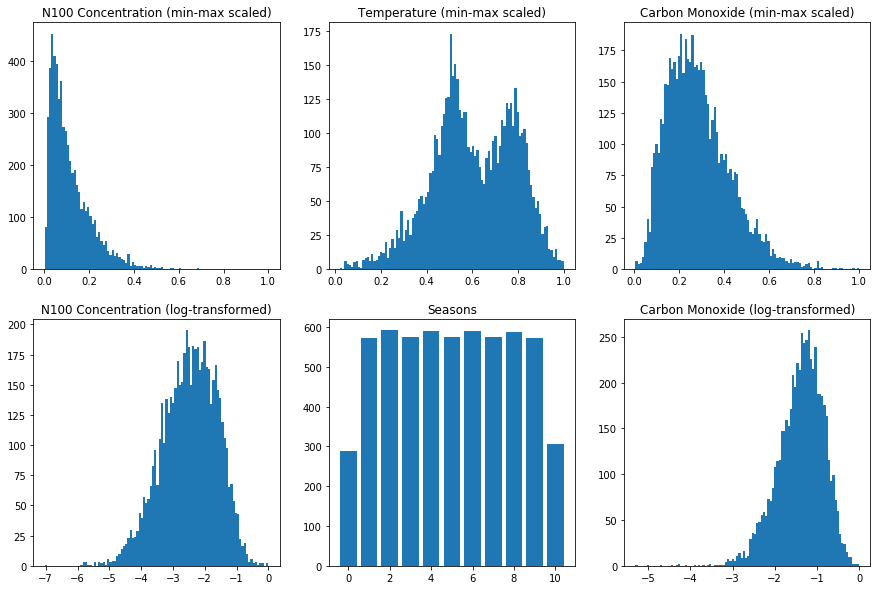

In [17]:
plot_distributions(df_scaled, df_comb, season)

N100 Concentration and Carbon Monoxide have a high positive skew and should therefore be log-tranformed

### Plotting the transformed data and moving averages

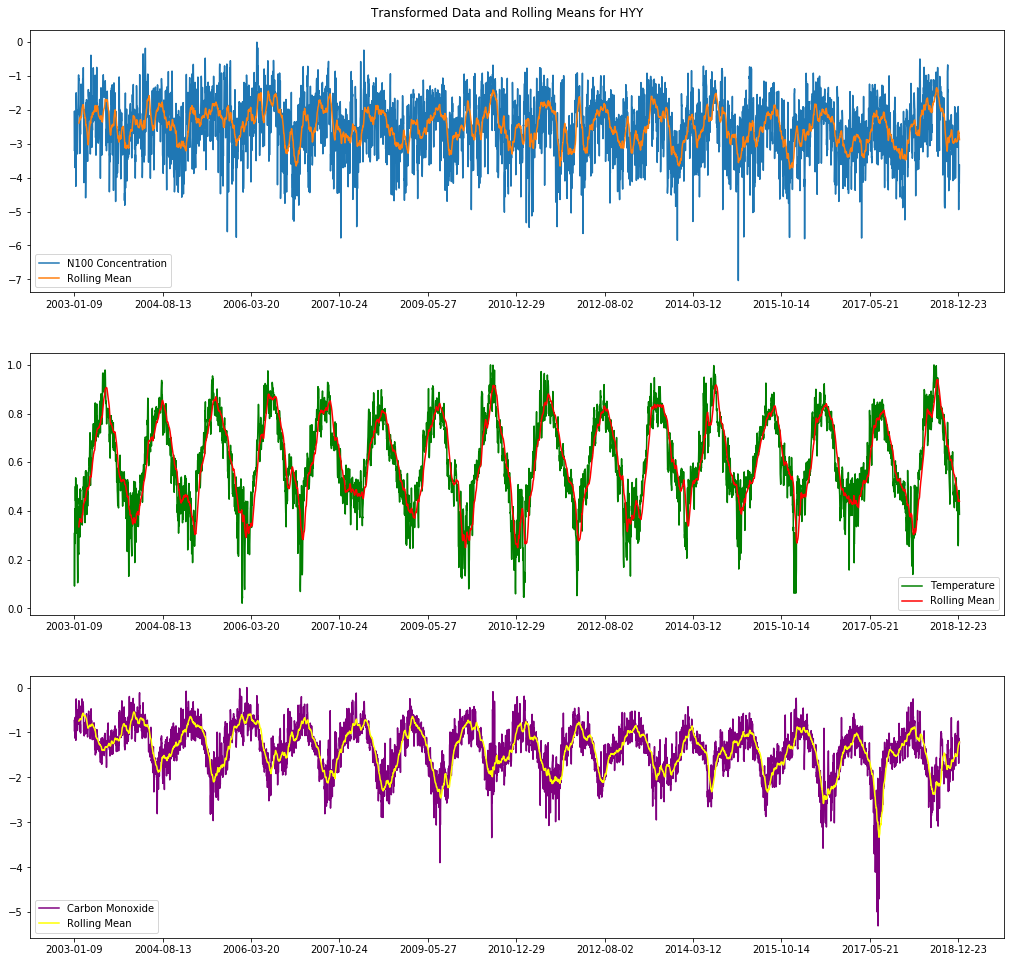

In [18]:
if not use_all_cities:
    plot_trends(df_comb, dates)

### Plotting correlations of N100 concentration vs. predictors 

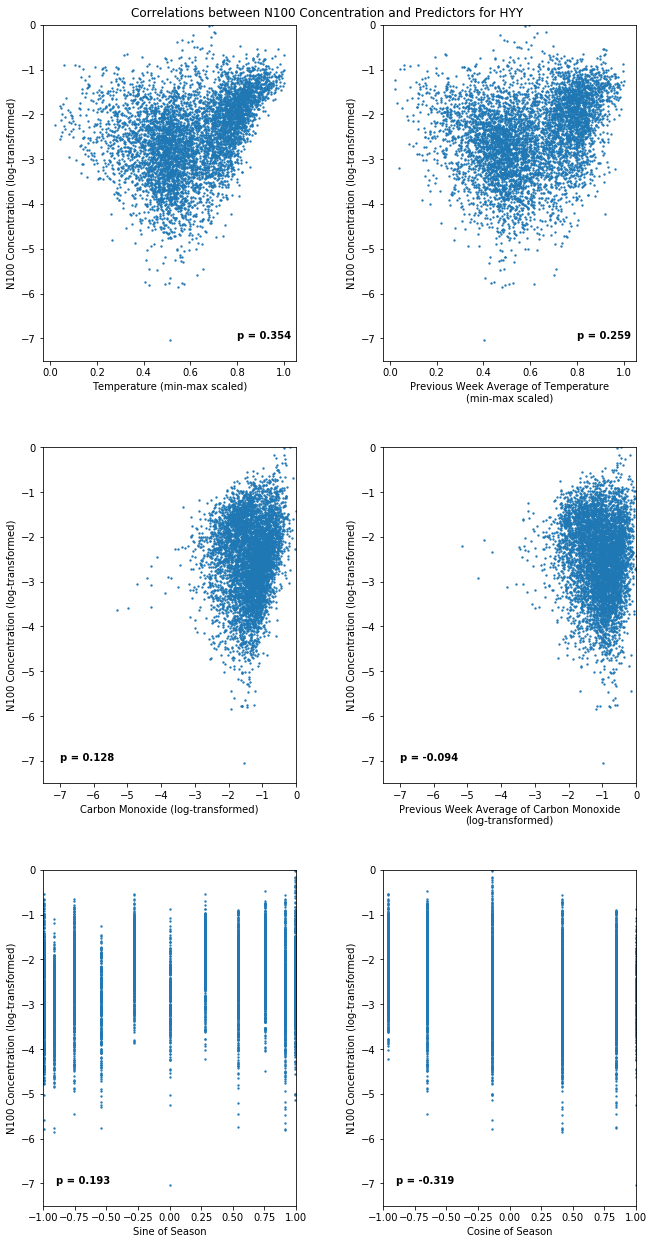

In [19]:
plot_correlations(df_comb)

## Temperature peaks experiments

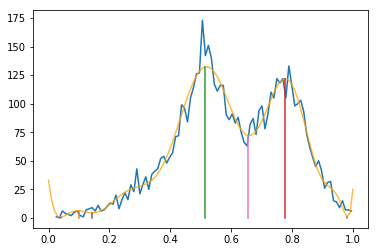

In [20]:
counts, values = np.histogram(df_comb.t, bins=100)
widths = values[1:] - values[:-1]
values = values[:-1] + (widths/2)
values = values.astype('float64')

deg = 13
poly = np.polyfit(values, counts, deg)

x = np.linspace(0, 1, 100)
y = np.zeros(x.shape)

for i in range(deg+1):
    y += poly[deg-i]*(x**i)
    
maxima = find_peaks(y)[0]
minima = argrelmin(y)[0]

t_split = x[minima][np.argmax(y[minima])]

plt.plot(values, counts)
plt.plot(x, y, c='orange', alpha=0.75)

for maximum in maxima:
    plt.plot(np.repeat(x[maximum], 2), np.array([0, y[maximum]]))
    
for minimum in minima:
    plt.plot(np.repeat(x[minimum], 2), np.array([0, y[minimum]]))

## Modelling
### Preparing the data

In [21]:
city_name = 'HYY'
no_seasons = 10
pwa = 14  # increasing from 7 to 14 improved R2 score from 0.312 to 0.319 when using whole dataset

# all: 0.313
use_all_cities = True
use_t = True
use_co = True
use_pwa = True
use_season = True
use_lat_lon = True

selected_city = select_cities(city_name)
predictors, eq_variables = select_predictors()
df, dates, season, numeric, non_numeric = create_df(no_seasons, pwa)

df_scaled, df_log = transform_df(df)
df, df_log, df_scaled, dates = remove_infinities(df, df_log, df_scaled, dates)
df_comb = combine_data(df, df_log, df_scaled)

df_comb.head()

Selected:
['ALE' 'ABZ' 'ASP' 'BOT' 'BSL' 'EGB' 'HEL' 'HPB' 'HYY' 'KCE' 'KPZ' 'MHD'
 'MAR' 'MLP' 'NAN' 'NEU' 'SAO' 'SCH' 'SGP' 'VIE' 'VAR' 'WAL'] 

Using predictors: ['t', 't_pwa', 'co', 'co_pwa', 'season_sin', 'season_cos', 'lat', 'lon'] 

Number of data points: 41896
Number of removed rows: 5
Number of data points: 41891 



,n100,t,t_pwa,co,co_pwa,season_sin,season_cos,lat,lon,city
0,-5.77282,0.0579482,0.0953345,-3.64006,-3.3754,0.540641,0.841254,0.916578,-0.347267,ALE
1,-5.77548,0.0808866,0.0898633,-3.62392,-3.38275,0.540641,0.841254,0.916578,-0.347267,ALE
2,-5.64149,0.0841786,0.0834568,-3.63228,-3.38332,0.540641,0.841254,0.916578,-0.347267,ALE
3,-5.8657,0.119293,0.0744492,-3.65716,-3.38194,0.540641,0.841254,0.916578,-0.347267,ALE
4,-5.99477,0.131649,0.0694986,-3.66456,-3.38179,0.540641,0.841254,0.916578,-0.347267,ALE


In [ ]:
# ONLY RUN WHEN USING HYY DATA
# ------------------------------------------------------
# creating a subset for datapoints with high temperature
t_split_mask = df_comb.t > t_split

df_high_t = df.loc[t_split_mask]
df_comb_high_t = df_comb.loc[t_split_mask]
dates_high_t = dates.loc[t_split_mask]

y_train, y_test, log_y_test, X_train, X_test, dates_test, min_max_scaler = split_data(df_high_t, df_comb_high_t, dates_high_t)

In [22]:
y_train, y_test, log_y_test, X_train, X_test, dates_test, min_max_scaler = split_data(df, df_comb, dates)

Train set shapes: (31418, 8) and (31418,)
Test set shapes: (10473, 8) and (10473,) 

Cities in test set: ['SCH', 'SGP', 'VIE', 'VAR', 'WAL']


### Linear Regression

Model equation:
log(N100) = 2.355*min_max(T) + 1.386*min_max(T_PWA) + 1.051*log(CO) - 0.247*log(CO_PWA) + 0.133*sin(Season) + 0.077*cos(Season) + 0.053*Lat + 1.403*Lon - 3.346

Correlation between observed and predicted log-transformed N100 concentration:
0.644

Correlation between observed and predicted N100 concentration:
0.581

R2 score on test set:
0.321

RMSE on test set:
490.333



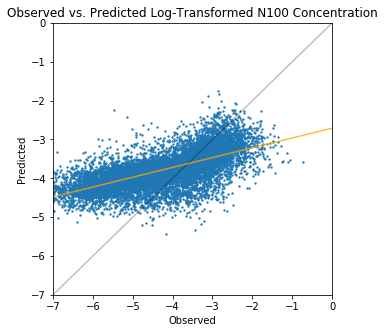

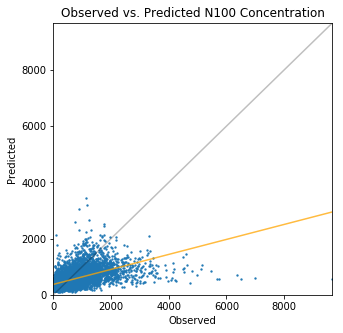

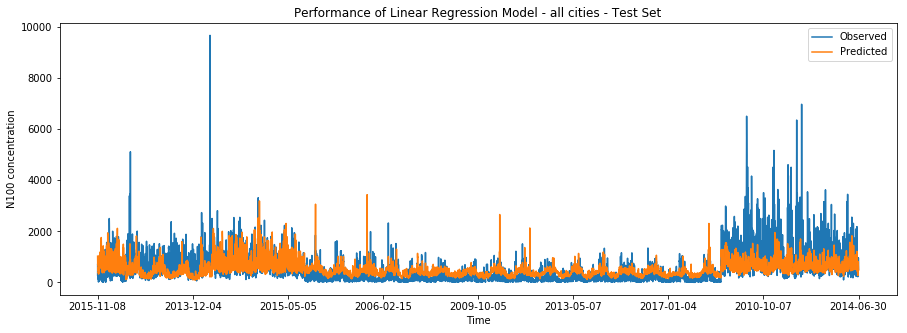

In [23]:
# Linear Regression
model = LinearRegression().fit(X_train, y_train)
predictions = model.predict(X_test)

# model evaluation
print_equation(model)
log_log_eval(predictions)

predictions = rev_trans(predictions)
corr_eval(predictions)
eval_model(predictions, model)
plot_results('Linear Regression', predictions)

### Random Forest Regression

Correlation between observed and predicted log-transformed N100 concentration:
0.733

Correlation between observed and predicted N100 concentration:
0.760

R2 score on test set:
0.578

RMSE on test set:
386.612



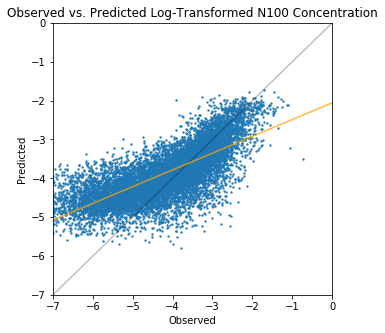

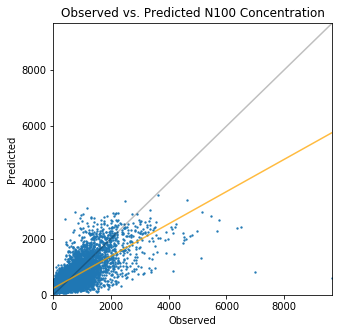

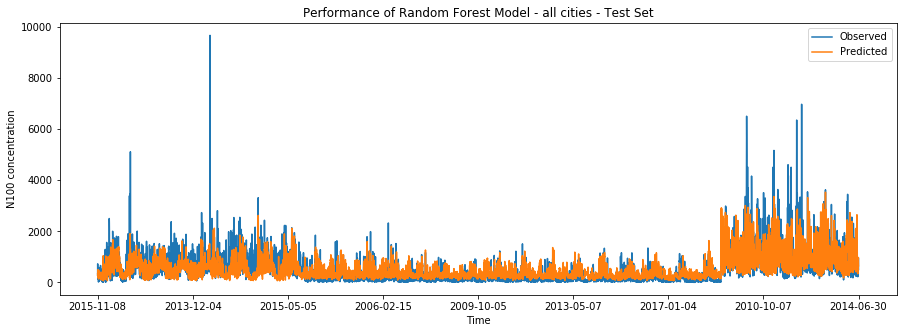

In [24]:
# Random Forest
model = RandomForestRegressor(n_estimators=15).fit(X_train, y_train)
predictions = model.predict(X_test)

# model evaluation
log_log_eval(predictions)

predictions = rev_trans(predictions)
corr_eval(predictions)
eval_model(predictions, model)
plot_results('Random Forest', predictions)